In [38]:
#importing all the libraries

import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [49]:
start_meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

#start_meta = start_meta.drop(columns=['dx_type'])
start_meta['age'] = start_meta['age'].fillna(start_meta['age'].mean())

scaler = StandardScaler()
start_meta['age'] = scaler.fit_transform(start_meta[['age']])

encoder = OneHotEncoder(sparse_output=False) 
cat_cols = ['sex', 'localization']
encoded_data_numpy = encoder.fit_transform(start_meta[cat_cols])
feature_names = encoder.get_feature_names_out(cat_cols)
encoded_data = pd.DataFrame(encoded_data_numpy, columns=feature_names, index=start_meta.index)

meta = pd.concat([start_meta[['lesion_id', 'image_id', 'dx', 'age']], encoded_data], axis=1)

unique_lesion_ids = meta['lesion_id'].unique()

train_ids, temp_ids = train_test_split(unique_lesion_ids, test_size=0.3)
test_ids, validation_ids = train_test_split(temp_ids, test_size=0.5)

train_meta = meta[meta['lesion_id'].isin(train_ids)]
test_meta = meta[meta['lesion_id'].isin(test_ids)]
validation_meta = meta[meta['lesion_id'].isin(validation_ids)]

print(f"train ({100 * len(train_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{train_meta.head()}\n")
print(f"test ({100 * len(test_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{test_meta.head()}\n")
print(f"validation ({100 * len(validation_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{validation_meta.head()}\n")


train (70.12481278082876%):
     lesion_id      image_id   dx       age  sex_female  sex_male  \
0  HAM_0000118  ISIC_0027419  bkl  1.662953         0.0       1.0   
1  HAM_0000118  ISIC_0025030  bkl  1.662953         0.0       1.0   
2  HAM_0002730  ISIC_0026769  bkl  1.662953         0.0       1.0   
3  HAM_0002730  ISIC_0025661  bkl  1.662953         0.0       1.0   
4  HAM_0001466  ISIC_0031633  bkl  1.367434         0.0       1.0   

   sex_unknown  localization_abdomen  localization_acral  localization_back  \
0          0.0                   0.0                 0.0                0.0   
1          0.0                   0.0                 0.0                0.0   
2          0.0                   0.0                 0.0                0.0   
3          0.0                   0.0                 0.0                0.0   
4          0.0                   0.0                 0.0                0.0   

   ...  localization_face  localization_foot  localization_genital  \
0  ...      

In [40]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, dir_part1, dir_part2, transform = None):
        self.annotation = dataframe
        self.dir_part1 = dir_part1
        self.dir_part2 = dir_part2
        self.transform = transform
        self.label_map = {
             'akiec': 0, 
             'bcc': 1, 
             'bkl': 2, 
             'df': 3, 
             'mel': 4, 
             'nv': 5, 
             'vasc': 6}
        self.meta_data_cols = self.annotation.drop(columns=[
            'lesion_id',
            'image_id',
            'dx'])
        
    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        img_id = self.annotation.iloc[index]['image_id']#ImageID on column 2

        path_part1 = os.path.join(self.dir_part1, img_id + '.jpg')
        path_part2 = os.path.join(self.dir_part2, img_id + '.jpg')
        if os.path.exists(path_part1):
            img_name = path_part1
        elif os.path.exists(path_part2):
            img_name = path_part2
        else:
            raise FileNotFoundError(f"Image {img_id} not found in part1 or part2")
            
        image = Image.open(img_name).convert('RGB')
        
        label_text = self.annotation.iloc[index]['dx']
        y_label = torch.tensor(self.label_map[label_text])

        meta_data = self.meta_data_cols.iloc[index].values.astype('float32')
        meta_data = torch.tensor(meta_data, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, y_label, meta_data



In [41]:
from torchvision import transforms

# Training transforms (Randomness added)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),    
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize(                # Standardizes to ImageNet distribution
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (No Randomness, just resizing)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
def get_device():
    if torch.cuda.is_available():
        print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    
    elif torch.backends.mps.is_available():
        print("✅ Apple Silicon GPU Detected")
        return torch.device("mps")
    
    else:
        print("⚠️ No GPU detected. Training will be slow.")
        return torch.device("cpu")


device = get_device()

✅ GPU Detected: Tesla P100-PCIE-16GB


In [43]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x
        

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #feature extraction
        self.block1 = DoubleConvBlock(3, 32)
        self.block2 = DoubleConvBlock(32, 64)
        self.block3 = DoubleConvBlock(64, 128)
        self.block4 = DoubleConvBlock(128, 256)
        
        self.flatten_size = 256 * 14 * 14
        
        # First fully connected layer
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.5)
        # Second fully connected layer 
        self.fc2 = nn.Linear(1024 + 19, 7)

    def forward(self, x, meta):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        #flatten the data
        x = x.view(-1, self.flatten_size)
        #FC layers
        x = F.leaky_relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)

        combined = torch.cat((x, meta), dim=1)
        
        x = self.fc2(combined)

        return x

skinCancerCNN = SkinCancerCNN()
print(skinCancerCNN)

SkinCancerCNN(
  (block1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): DoubleConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_s

In [44]:
criterion = nn.CrossEntropyLoss(weight=None)

In [45]:
learning_rate = 0.0003

optimizer = optim.Adam(skinCancerCNN.parameters(), learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)


In [51]:
# Define your paths (Adjust these to match your specific Kaggle input structure)
dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Create Datasets passing BOTH directories
train_dataset = SkinCancerDataset(train_meta, dir_1, dir_2, transform=train_transforms)
val_dataset = SkinCancerDataset(validation_meta, dir_1, dir_2, transform=val_transforms)
test_dataset = SkinCancerDataset(test_meta, dir_1, dir_2, transform=val_transforms)

label_map = {
    'akiec': 0,
    'bcc' : 1,
    'bkl' : 2,
    'df' : 3,
    'mel' : 4,
    'nv' : 5,
    'vasc' : 6,
}

#create sampler weights
labels, counts = np.unique(meta['dx'], return_counts=True)
weights = 1.0 / np.sqrt(counts) 
weights = weights / weights.sum() * len(counts)

print(labels, label_map)

sample_weights = [weights[label_map[label]] for label in train_meta['dx']]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           sampler=sampler)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'] {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [47]:
import time
from tqdm import tqdm # Library for progress bars
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
patience = 20        # How many epochs to wait before stopping if no improvement
min_delta = 0.0005   # Minimum change to qualify as an improvement
early_stop_counter = 0
best_val_loss = float('inf')
num_epochs = 100

# Move model to device
model = skinCancerCNN.to(device)

# History storage
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"🚀 Starting training on {device} with Early Stopping...")

# ==========================================
# TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    
    # --- 1. Training Phase ---
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    # 'desc' sets the text before the bar
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for images, labels, meta_data in loop:
        images, labels, meta_data = images.to(device), labels.to(device), meta_data.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, meta_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_loss)

    # --- 2. Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, meta_data in val_loader:
            images, labels, meta_data = images.to(device), labels.to(device), meta_data.to(device)
            outputs = model(images, meta_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_acc = 100 * correct / total
    
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_acc)
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Print Clean Stats
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}% | "
          f"Learning Rate: {current_lr:.6f}")

    # ==========================================
    # EARLY STOPPING LOGIC
    # ==========================================
    # Check if this validation loss is the best we've seen
    if epoch_val_loss < (best_val_loss - min_delta):
        best_val_loss = epoch_val_loss
        early_stop_counter = 0 # Reset counter
        torch.save(model.state_dict(), 'best_skin_cancer_model.pth')
        print(f"   ✅ Validation Loss Improved. Model Saved.")
    else:
        early_stop_counter += 1
        print(f"   ⚠️ No improvement for {early_stop_counter}/{patience} epochs.")
        
    if early_stop_counter >= patience:
        print(f"\n🛑 Early Stopping Triggered! Training stopped at Epoch {epoch+1}.")
        break

print("Training Finished.")

# ==========================================
# VISUALIZATION
# ==========================================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Run the plot
plot_training_history(history)      
       

🚀 Starting training on cuda with Early Stopping...


Epoch [1/100]  Train Loss: 1.3156 | Val Loss: 0.8908 | Val Acc: 65.36% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [2/100]  Train Loss: 1.0978 | Val Loss: 0.7959 | Val Acc: 70.85% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [3/100]  Train Loss: 1.0167 | Val Loss: 0.6255 | Val Acc: 76.75% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [4/100]  Train Loss: 0.9226 | Val Loss: 0.6542 | Val Acc: 75.46% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [5/100]  Train Loss: 0.8833 | Val Loss: 0.6556 | Val Acc: 74.92% | Learning Rate: 0.000300
   ⚠️ No improvement for 2/20 epochs.


Epoch [6/100]  Train Loss: 0.8662 | Val Loss: 0.5594 | Val Acc: 78.71% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [7/100]  Train Loss: 0.8043 | Val Loss: 0.5822 | Val Acc: 78.03% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [8/100]  Train Loss: 0.8043 | Val Loss: 0.5536 | Val Acc: 79.66% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [9/100]  Train Loss: 0.7841 | Val Loss: 0.5687 | Val Acc: 78.44% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [10/100]  Train Loss: 0.7579 | Val Loss: 0.5896 | Val Acc: 77.22% | Learning Rate: 0.000300
   ⚠️ No improvement for 2/20 epochs.


Epoch [11/100]  Train Loss: 0.7318 | Val Loss: 0.6202 | Val Acc: 76.47% | Learning Rate: 0.000300
   ⚠️ No improvement for 3/20 epochs.


Epoch [12/100]  Train Loss: 0.7548 | Val Loss: 0.6428 | Val Acc: 75.19% | Learning Rate: 0.000300
   ⚠️ No improvement for 4/20 epochs.


Epoch [13/100]  Train Loss: 0.7173 | Val Loss: 0.5471 | Val Acc: 78.98% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [14/100]  Train Loss: 0.6862 | Val Loss: 0.5791 | Val Acc: 78.64% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [15/100]  Train Loss: 0.6934 | Val Loss: 0.5934 | Val Acc: 77.08% | Learning Rate: 0.000300
   ⚠️ No improvement for 2/20 epochs.


Epoch [16/100]  Train Loss: 0.6834 | Val Loss: 0.6218 | Val Acc: 76.47% | Learning Rate: 0.000300
   ⚠️ No improvement for 3/20 epochs.


Epoch [17/100]  Train Loss: 0.6585 | Val Loss: 0.6182 | Val Acc: 76.41% | Learning Rate: 0.000300
   ⚠️ No improvement for 4/20 epochs.


Epoch [18/100]  Train Loss: 0.6618 | Val Loss: 0.5552 | Val Acc: 79.25% | Learning Rate: 0.000300
   ⚠️ No improvement for 5/20 epochs.


Epoch [19/100]  Train Loss: 0.6588 | Val Loss: 0.5594 | Val Acc: 79.46% | Learning Rate: 0.000300
   ⚠️ No improvement for 6/20 epochs.


Epoch [20/100]  Train Loss: 0.6297 | Val Loss: 0.5460 | Val Acc: 79.93% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [21/100]  Train Loss: 0.6233 | Val Loss: 0.5720 | Val Acc: 77.83% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [22/100]  Train Loss: 0.6021 | Val Loss: 0.4781 | Val Acc: 82.10% | Learning Rate: 0.000300
   ✅ Validation Loss Improved. Model Saved.


Epoch [23/100]  Train Loss: 0.6094 | Val Loss: 0.5484 | Val Acc: 80.00% | Learning Rate: 0.000300
   ⚠️ No improvement for 1/20 epochs.


Epoch [24/100]  Train Loss: 0.5868 | Val Loss: 0.5827 | Val Acc: 78.58% | Learning Rate: 0.000300
   ⚠️ No improvement for 2/20 epochs.


Epoch [25/100]  Train Loss: 0.5840 | Val Loss: 0.5367 | Val Acc: 80.81% | Learning Rate: 0.000300
   ⚠️ No improvement for 3/20 epochs.


Epoch [26/100]  Train Loss: 0.5803 | Val Loss: 0.5204 | Val Acc: 81.76% | Learning Rate: 0.000300
   ⚠️ No improvement for 4/20 epochs.


Epoch [27/100]  Train Loss: 0.5665 | Val Loss: 0.4953 | Val Acc: 82.51% | Learning Rate: 0.000300
   ⚠️ No improvement for 5/20 epochs.


Epoch [28/100]  Train Loss: 0.5637 | Val Loss: 0.5361 | Val Acc: 81.36% | Learning Rate: 0.000300
   ⚠️ No improvement for 6/20 epochs.


Epoch [29/100]  Train Loss: 0.5308 | Val Loss: 0.5046 | Val Acc: 82.58% | Learning Rate: 0.000300
   ⚠️ No improvement for 7/20 epochs.


Epoch [30/100]  Train Loss: 0.5403 | Val Loss: 0.5051 | Val Acc: 80.95% | Learning Rate: 0.000150
   ⚠️ No improvement for 8/20 epochs.


Epoch [31/100]  Train Loss: 0.4983 | Val Loss: 0.5056 | Val Acc: 81.90% | Learning Rate: 0.000150
   ⚠️ No improvement for 9/20 epochs.


Epoch [32/100]  Train Loss: 0.4756 | Val Loss: 0.5008 | Val Acc: 81.49% | Learning Rate: 0.000150
   ⚠️ No improvement for 10/20 epochs.


Epoch [33/100]  Train Loss: 0.4830 | Val Loss: 0.5003 | Val Acc: 81.02% | Learning Rate: 0.000150
   ⚠️ No improvement for 11/20 epochs.


Epoch [34/100]  Train Loss: 0.4500 | Val Loss: 0.4875 | Val Acc: 82.03% | Learning Rate: 0.000150
   ⚠️ No improvement for 12/20 epochs.


Epoch [35/100]  Train Loss: 0.4676 | Val Loss: 0.4855 | Val Acc: 82.44% | Learning Rate: 0.000150
   ⚠️ No improvement for 13/20 epochs.


Epoch [36/100]  Train Loss: 0.4483 | Val Loss: 0.4597 | Val Acc: 82.44% | Learning Rate: 0.000150
   ✅ Validation Loss Improved. Model Saved.


Epoch [37/100]  Train Loss: 0.4478 | Val Loss: 0.4762 | Val Acc: 82.64% | Learning Rate: 0.000150
   ⚠️ No improvement for 1/20 epochs.


Epoch [38/100]  Train Loss: 0.4414 | Val Loss: 0.4741 | Val Acc: 82.51% | Learning Rate: 0.000150
   ⚠️ No improvement for 2/20 epochs.


Epoch [39/100]  Train Loss: 0.4374 | Val Loss: 0.4930 | Val Acc: 83.05% | Learning Rate: 0.000150
   ⚠️ No improvement for 3/20 epochs.


Epoch [40/100]  Train Loss: 0.4180 | Val Loss: 0.5147 | Val Acc: 82.92% | Learning Rate: 0.000150
   ⚠️ No improvement for 4/20 epochs.


Epoch [41/100]  Train Loss: 0.4365 | Val Loss: 0.4673 | Val Acc: 83.80% | Learning Rate: 0.000150
   ⚠️ No improvement for 5/20 epochs.


Epoch [42/100]  Train Loss: 0.4251 | Val Loss: 0.4927 | Val Acc: 82.92% | Learning Rate: 0.000150
   ⚠️ No improvement for 6/20 epochs.


Epoch [43/100]  Train Loss: 0.4063 | Val Loss: 0.4930 | Val Acc: 83.05% | Learning Rate: 0.000150
   ⚠️ No improvement for 7/20 epochs.


Epoch [44/100]  Train Loss: 0.4045 | Val Loss: 0.4977 | Val Acc: 82.31% | Learning Rate: 0.000075
   ⚠️ No improvement for 8/20 epochs.


Epoch [45/100]  Train Loss: 0.3725 | Val Loss: 0.4952 | Val Acc: 82.92% | Learning Rate: 0.000075
   ⚠️ No improvement for 9/20 epochs.


Epoch [46/100]  Train Loss: 0.3730 | Val Loss: 0.4865 | Val Acc: 83.19% | Learning Rate: 0.000075
   ⚠️ No improvement for 10/20 epochs.


Epoch [47/100]  Train Loss: 0.3565 | Val Loss: 0.4894 | Val Acc: 82.51% | Learning Rate: 0.000075
   ⚠️ No improvement for 11/20 epochs.


Epoch [48/100]  Train Loss: 0.3705 | Val Loss: 0.4904 | Val Acc: 83.66% | Learning Rate: 0.000075
   ⚠️ No improvement for 12/20 epochs.


Epoch [49/100]  Train Loss: 0.3462 | Val Loss: 0.4890 | Val Acc: 82.58% | Learning Rate: 0.000075
   ⚠️ No improvement for 13/20 epochs.


Epoch [50/100]  Train Loss: 0.3537 | Val Loss: 0.4780 | Val Acc: 82.58% | Learning Rate: 0.000075
   ⚠️ No improvement for 14/20 epochs.


Epoch [51/100]  Train Loss: 0.3465 | Val Loss: 0.4857 | Val Acc: 84.00% | Learning Rate: 0.000075
   ⚠️ No improvement for 15/20 epochs.


Epoch [52/100]  Train Loss: 0.3543 | Val Loss: 0.5121 | Val Acc: 82.03% | Learning Rate: 0.000037
   ⚠️ No improvement for 16/20 epochs.


Epoch [53/100]  Train Loss: 0.3349 | Val Loss: 0.4747 | Val Acc: 83.32% | Learning Rate: 0.000037
   ⚠️ No improvement for 17/20 epochs.


Epoch [54/100]  Train Loss: 0.3198 | Val Loss: 0.4725 | Val Acc: 84.34% | Learning Rate: 0.000037
   ⚠️ No improvement for 18/20 epochs.


KeyboardInterrupt: 

✅ Successfully loaded the best saved model.
🔄 Processing validation set for Confusion Matrix...
✅ Predictions complete.
---ACCURACY---
89.44!!

---




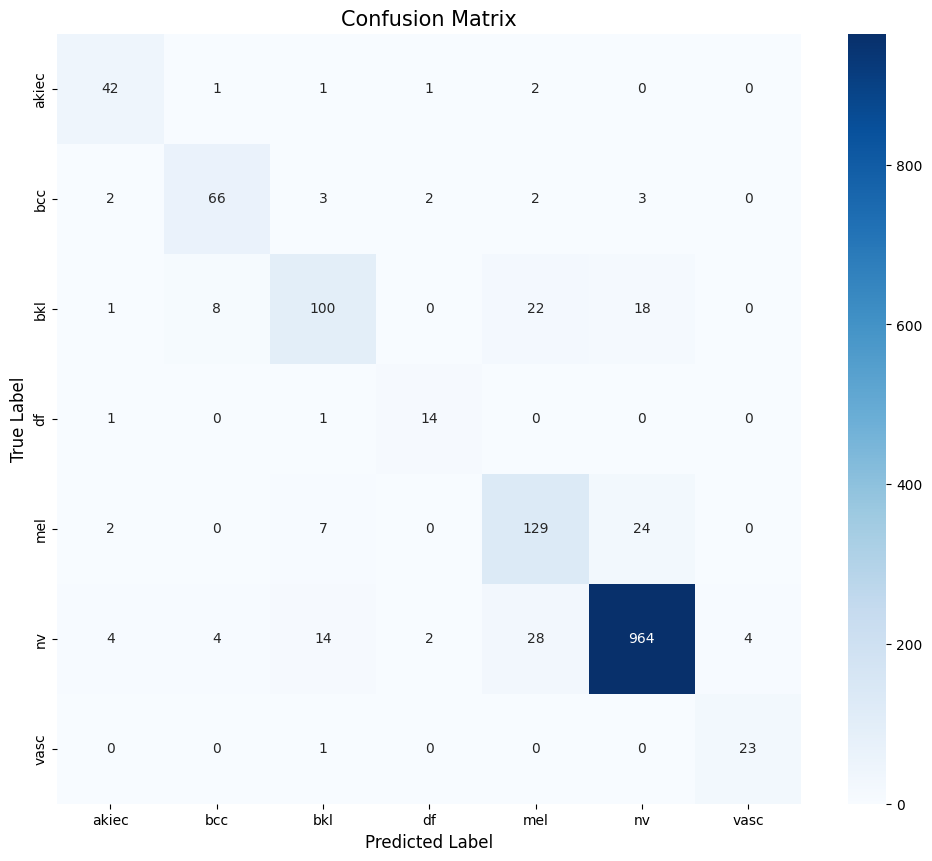


📋 Classification Report:

              precision    recall  f1-score   support

       akiec       0.81      0.89      0.85        47
         bcc       0.84      0.85      0.84        78
         bkl       0.79      0.67      0.72       149
          df       0.74      0.88      0.80        16
         mel       0.70      0.80      0.75       162
          nv       0.96      0.95      0.95      1020
        vasc       0.85      0.96      0.90        24

    accuracy                           0.89      1496
   macro avg       0.81      0.86      0.83      1496
weighted avg       0.90      0.89      0.89      1496



In [61]:
 # Confusion Matrix
model = skinCancerCNN.to(device)
y_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Load the weights from the file saved during training
# (This requires 'best_skin_cancer_model.pth' to exist in your current folder)
try:
    model.load_state_dict(torch.load('best_skin_cancer_model.pth'))
    print("✅ Successfully loaded the best saved model.")
except FileNotFoundError:
    print("⚠️ File not found. Using current model weights instead.")

model.eval() # Set to evaluation mode (Turns off Dropout)

# 2. PREDICTION LOOP: Get all predictions for the validation set
y_true = []
y_pred = []
correct = 0
total = 0

print("🔄 Processing validation set for Confusion Matrix...")

with torch.no_grad(): # Save memory, we don't need gradients here
    for images, labels, meta_data in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        meta_data = meta_data.to(device)
        
        # Forward pass
        outputs = model(images, meta_data)
        
        # Get the class with the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total
        
        # Move back to CPU and convert to numpy for Sklearn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("✅ Predictions complete.")

# 3. COMPUTE & PLOT: Create the Matrix
print(f"---ACCURACY---\n{test_acc:.2f}!!\n\n---\n\n")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

# 4. REPORT: Print Precision, Recall, and F1-Score
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=y_labels))